# Alternative plots for max|TE|

In [1]:
import sys, os, logging
sys.path.append(os.path.abspath('../'))
import ptp.metrics
import ptp.datasets
import ptp.reader
import analyze
import matplotlib.pyplot as plt
import numpy as np
from cycler import cycler
%matplotlib inline 
%load_ext autoreload
%autoreload 2

In [2]:
args = analyze.parse_args()

## Read cache

Before running the notebook make sure to have the cached file with the max|TE| results with the right naming convention.

In [3]:
args.file   = "serial-20200729-104054"
args.prefix = "20200729_104054_pts"
args.skip   = 0.25

In [4]:
ds = analyze.read_dataset(args)

In [5]:
T = ds['data'].metadata["sync_period"]

In [6]:
analyser = ptp.metrics.Analyser(ds['data'].data, ds['path'], cache=ds['cache'], skip=args.skip)
analyser.load_maxte_and_mtie_cache()

## Plot #1 - Boxplot

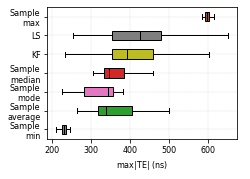

In [7]:
%matplotlib inline
analyser.plot_max_te(show_raw=False, plottype='boxplot', window_len=int(60/T), save=False)

## Plot #2 - Violin plot

It is similar to a box plot, with the addition of a rotated kernel density plot on each side

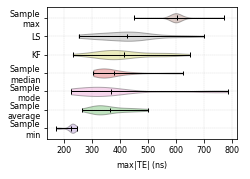

In [8]:
%matplotlib inline
analyser.plot_max_te(show_raw=False, plottype='violin', window_len=int(60/T), save=False)

## Plot #3 - Error bar

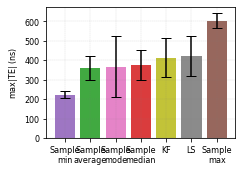

In [9]:
%matplotlib inline
analyser.plot_max_te(show_raw=False, plottype='bar', window_len=int(60/T), save=False)

## Subplot: Error bar

In [10]:
def _configure_labels(max_te_dict, remove_raw=True):
    labels_map = {
        "x_est"                : {"label": "Raw"},
        "x"                    : {"label": "True Values"},
        "x_pkts_avg"           : {"label": "Sample average"},
        "x_pkts_median"        : {"label": "Sample median"},
        "x_pkts_min"           : {"label": "Sample min"},
        "x_pkts_max"           : {"label": "Sample max"},
        "x_pkts_mode"          : {"label": "Sample mode"},
        "x_ls_eff"             : {"label": "LS"},
        "x_kf"                 : {"label": "KF"},
        "x_loop"               : {"label": "TLL"},
        "x_pkts_ewma"          : {"label": "EWMA"},
        "x_ls_t2"              : {"label": "LS (t2)"},
        "x_ls_t1"              : {"label": "LS (t1)"}
    }
    
    # Break labels
    for k,v in labels_map.items():
        labels_map[k]['label'] = v['label'].replace(' ', '\n')
    
    # Colors
    color_cycle = plt.rcParams['axes.prop_cycle']()
    for k in labels_map:
        labels_map[k]['color'] = next(color_cycle)['color']
    
    # Remove raw
    if (remove_raw and 'x_est' in max_te_dict):
        max_te_dict.pop('x_est')
        
    return labels_map

In [11]:
max_te = {}
prefix = args.prefix.replace('_pts', '')
for ds_type in ['pts', 'apts']:
    cache           = ptp.cache.Cache(ds['path'], f'{prefix}_{ds_type}')
    max_te[ds_type] = cache.load('max_te')
    assert(len(max_te) > 0), f"No cache available for ds: {ds['path']}"

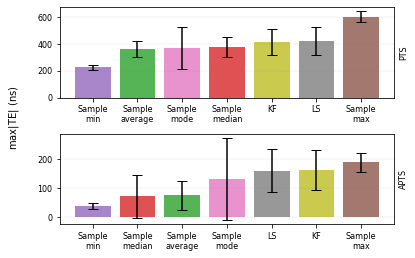

In [12]:
fig, axs = plt.subplots(2, 1)

for i, ds_type in enumerate(['pts', 'apts']):
    labels_map = _configure_labels(max_te[ds_type])
    
    sorted_max_te = {k: v for k,v in sorted(max_te[ds_type].items(), key=lambda item: np.mean(item[1]), reverse=False)}
    max_te_est    = sorted_max_te.values()
    labels        = [labels_map[key]['label'] for key in sorted_max_te.keys()]
    colors        = [labels_map[key]['color'] for key in sorted_max_te.keys()]
    
    max_te_est_mean = np.array([val for val in max_te_est]).mean(axis=1)
    max_te_est_std  = np.array([val for val in max_te_est]).std(axis=1)
    position        = range(len(labels))

    axs[i].bar(position, max_te_est_mean, yerr=max_te_est_std, align='center',
               alpha=0.8, ecolor='black', capsize=5, color=colors)
    axs[i].set_xticks(position)
    axs[i].set_xticklabels(labels)
    
    axs[i].set_ylabel('$\max|$TE$|$ (ns)')
    axs[i].grid(axis='y', color='grey', linestyle=':', linewidth=0.25)
    
    axs[i].set_ylabel(f'{ds_type.upper()}', rotation=90, labelpad=5)
    axs[i].yaxis.set_label_position("right")
    
fig.text(0.02, 0.4, '$\max|$TE$|$ (ns)', ha='center', rotation='vertical')
plt.subplots_adjust(hspace=0.4)